In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.expanduser("~"),"Documents","metabolic_network","metconsin"))
sys.path.append(os.path.join(os.path.expanduser("~"),"Documents","Data","isolate_data"))
import pandas as pd
from pathlib import Path
import datetime as dt
import pickle
import importlib as il
import cobra as cb
import numpy as np
import time

import matplotlib.pyplot as plt


import surfmod as sm
import prep_models as pr
import dynamic_simulation as surf

from scipy.integrate import solve_ivp


In [141]:
model_info = pd.read_csv(os.path.join(os.path.expanduser("~"),"Documents","Data","isolate_data","ModelSeed_info.csv"))#pd.read_csv("bigg_model_file_info.txt")

cbmods = {}

desired_models = ["bc1012","bc1011"]#["E.coli"]#,"P.putida"]#,"S.cerevisiae","M.tuberculosis",

cobra_models = {}

for mod in desired_models:
    if any(model_info.Species == mod):
        flnm = os.path.join(os.path.expanduser("~"),"Documents","Data","isolate_data",model_info.loc[model_info.Species == mod,'File'].iloc[0])
        cobra_models[mod] = cb.io.read_sbml_model(flnm)
        if not cobra_models[mod].name:
            cobra_models[mod].name = mod
        mxg = cobra_models[mod].slim_optimize()
        min_med = cb.medium.minimal_medium(cobra_models[mod],mxg)#,minimize_components = True)
        cobra_models[mod].medium = min_med
    else:
        print("Error: No model of species " + mod)

models,metlist,y0dict = pr.prep_cobrapy_models(cobra_models,ub_funs = "linearScale",forceOns=True)

y0 = np.array([y0dict[met] for met in metlist])


bc1012  Upper Bounds: Using linear uptake with uniform coefficients = 1.0
bc1012  Lower Bounds: Using constant uptake
bc1011  Upper Bounds: Using linear uptake with uniform coefficients = 1.0
bc1011  Lower Bounds: Using constant uptake


In [142]:
metaabs = {}
y0s = {}
exrn = {}
metabids = {}
nametoid = {}
exrn_to_exmet = {}
exmet_to_exrn = {}
for modelkey in cobra_models.keys():
    model = cobra_models[modelkey]

    #list all reactions the model claims are exchange.
    exchng_reactions = [rxn.id for rxn in model.reactions if 'EX_' in rxn.id]#


    exchng_metabolite_ids_wrx = [(rx,metab.id) for rx in exchng_reactions for metab in model.reactions.get_by_id(rx).reactants] #
    exrxn_to_met = dict(exchng_metabolite_ids_wrx)
    met_to_exrxn = dict([(t[1],t[0]) for t in exchng_metabolite_ids_wrx])
    exchng_metabolite_ids = [t[1] for t in exchng_metabolite_ids_wrx]


    exchng_metabolite_names = [model.metabolites.get_by_id(metab).name for metab in exchng_metabolite_ids]


    idtonm = dict(zip(exchng_metabolite_ids,exchng_metabolite_names))
    nmtoid = dict(zip(exchng_metabolite_names,exchng_metabolite_ids))

    environment = {}
    for rxn in model.medium:
        for met in model.reactions.get_by_id(rxn).reactants:
            environment[met.id] = model.medium[rxn]

    y_init = {}
    for metabo in exchng_metabolite_names:
        if metabo in environment.keys():
            y_init[metabo] = environment[metabo]
        elif nmtoid[metabo] in environment.keys():
            y_init[metabo] = environment[nmtoid[metabo]]
        elif any([nmtoid[metabo] in rx.reactants for rx in model.reactions]):
            y_init[metabo] = np.mean([environment[rx.id] for rx in model.reactions if metabo in rx.reactants])




    metaabs[model.name] = exchng_metabolite_names
    metabids[model.name] = exchng_metabolite_ids
    y0s[model.name] = y_init
    exrn[model.name] = exchng_reactions
    nametoid[model.name] = nmtoid
    exrn_to_exmet[model.name] = exrxn_to_met
    exmet_to_exrn[model.name] = met_to_exrxn





##### NOW: we have to reconcile the exchanged metabolites. Swapping order means swapping rows of GammaStar! So
### we must agree on an order.
masterlist = []
for li in metaabs.values():
    masterlist += li
masterlist = np.unique(masterlist)



#### Initial y is not as difficult. I'll take the highest.
master_y0 = {}
for nm in masterlist:
    yyy0 = 0
    # ctt = 0
    for mod in y0s.values():
        if nm in mod.keys():
            yyy0 = max(yyy0,mod[nm])
    master_y0[nm] = yyy0


In [148]:
for mod in cobra_models:
    med = dict([(exmet_to_exrn[cobra_models[mod].name][nametoid[cobra_models[mod].name][ky]],val) for ky,val in master_y0.items() if ky in nametoid[cobra_models[mod].name].keys()])
    cobra_models[mod].medium = med

In [149]:
modellist = list(cobra_models.keys())

In [184]:
def cobra_sys(t,s,models,modlist,metlist,nmtoid,exmtoexr):
    x = s[:len(models)]
    y = s[len(models):]
    dxdt = np.zeros_like(x)
    dydt = np.zeros_like(y)
    for i in range(len(modlist)):
        med = dict([(exmtoexr[modlist[i]][nmtoid[modlist[i]][metlist[k]]],y[k]) for k in range(len(y)) if metlist[k] in nametoid[modlist[i]].keys()])
        models[modlist[i]].medium = med
        opt = models[modlist[i]].optimize()
        try:
            dxdt[i] = x[i]*opt.objective_value
            for j in range(len(metlist)):
                if metlist[j] in nametoid[modlist[i]].keys():
                    dydt[j] += x[i]*opt.fluxes[exmtoexr[modlist[i]][nmtoid[modlist[i]][metlist[j]]]]
        except:
            dxdt[i] = 0
    return np.concatenate([dxdt,dydt])
    

In [185]:
ivpsolve = solve_ivp(cobra_sys, (0,1),np.concatenate([[1],y0]),args = (cobra_models,modellist,masterlist,nametoid,exmet_to_exrn))

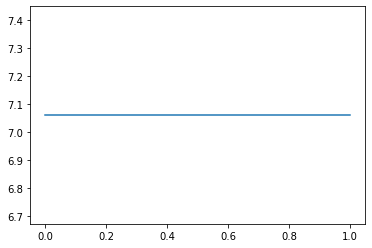

In [186]:
plt.plot(ivpsolve.t,ivpsolve.y[1])

In [188]:
ivpsolve.y[1]

array([7.06019001, 7.06019001, 7.06019001, 7.06019001, 7.06019001,
       7.06019001, 7.06019001, 7.06019001])